**Prédiction à partir des données collectées sur OpenStreetMap : Où installer une borne dans une grille ?**

Pour déterminer les emplacements optimaux pour installer une borne de recharge ou tout autre équipement, nous exploitons les données géographiques et contextuelles collectées via OpenStreetMap. Ces données nous permettent d'identifier les zones à fort potentiel en analysant plusieurs facteurs clés, notamment :

- La densité de population.
- La proximité des infrastructures telles que les restaurants, parkings, écoles, etc.
- Les caractéristiques spécifiques de chaque grille géographique.

**Méthodologie**

Nous utilisons des algorithmes de classification pour modéliser et prédire les besoins en installation dans les grilles géographiques :
- **Random Forest** : Permet de capturer les relations complexes entre les caractéristiques.
- **Gradient Boosting (XGBoost)** : Optimise les performances, en particulier sur des données déséquilibrées.

Ces algorithmes sont évalués sur des critères, tels que :
- **Accuracy** : Proportion des prédictions correctes.
- **Recall** : Capacité à identifier correctement les zones nécessitant une borne.
- **F1-score** : Équilibre entre précision et rappel(Recall)

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from prophet import Prophet
import requests

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('paris_df.csv')


In [4]:
df.head()

,Unnamed: 0,geometry,ev_stations_counts,ev_stations_geometries,parking_counts,restaurant_counts,library_counts,university_counts,school_counts,park_counts,cinema_counts,place_of_worship_counts,retail_counts,commercial,nodes,edges,road_density,pop_density
0,0,"POLYGON ((2.224122 48.854199, 2.224158 48.8546...",0,[],8,1,0,0,0,0,0,0,0,0,7,11,0.261905,36.212502
1,1,"POLYGON ((2.22770203977798 48.86367577777778, ...",0,[],0,1,0,0,0,0,0,0,0,0,3,3,0.500000,36.212502
2,2,"POLYGON ((2.233947528 48.85405572222222, 2.233...",0,[],0,0,0,0,0,0,0,0,0,0,0,0,0.000000,36.212502
3,3,"POLYGON ((2.233947528 48.8700614172126, 2.2340...",0,[],1,1,0,0,0,0,0,0,0,0,20,28,0.073684,36.212502
4,4,POLYGON ((2.2423216293887602 48.87329583333333...,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000


In [5]:
df = df.drop(columns=['Unnamed: 0','ev_stations_geometries'])

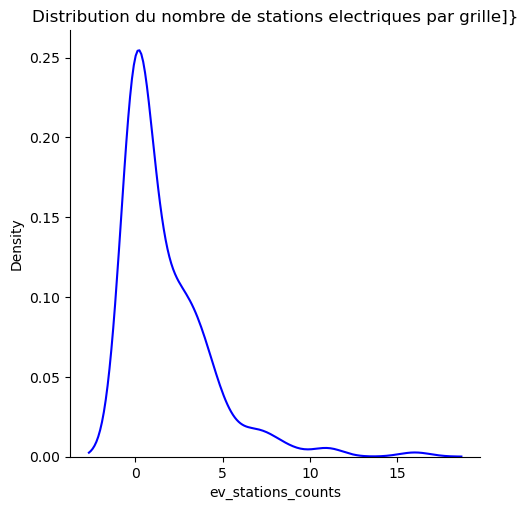

In [6]:
# Create the distribution plot without x-axis values

sns.displot(df['ev_stations_counts'], color='Blue', kind='kde')
plt.title('Distribution du nombre de stations electriques par grille]}')
plt.show()

In [7]:
# Filter for numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculate summary statistics and transpose
summary_stats = df_numeric.describe().T 

# Sort by standard deviation in descending order
sorted_stats = summary_stats.sort_values(by='std', ascending=False)

# Apply styling: background gradient and bar charts
styled_stats = sorted_stats.style.background_gradient(cmap='GnBu') \
                          .bar(subset=['max'], color='#BB0000') \
                          .bar(subset=['mean'], color='green') 

# Display the styled DataFrame
styled_stats


,count,mean,std,min,25%,50%,75%,max
edges,174.000000,89.735632,68.299994,0.000000,15.500000,100.500000,143.750000,227.000000
restaurant_counts,174.000000,48.936782,65.168714,0.000000,1.000000,25.500000,68.750000,345.000000
nodes,174.000000,53.155172,38.516479,0.000000,10.500000,60.500000,85.750000,130.000000
pop_density,174.000000,39.224063,12.996985,0.000000,30.947661,39.762516,46.848177,66.974038
parking_counts,174.000000,5.850575,9.955425,0.000000,1.000000,3.000000,6.750000,74.000000
school_counts,174.000000,6.660920,6.569765,0.000000,0.000000,6.000000,11.750000,30.000000
retail_counts,174.000000,4.195402,6.500047,0.000000,0.000000,2.000000,5.000000,40.000000
park_counts,174.000000,3.258621,3.764269,0.000000,0.000000,2.000000,5.000000,19.000000
place_of_worship_counts,174.000000,2.212644,2.661144,0.000000,0.000000,1.000000,4.000000,12.000000
ev_stations_counts,174.000000,1.718391,2.495315,0.000000,0.000000,1.000000,3.000000,16.000000


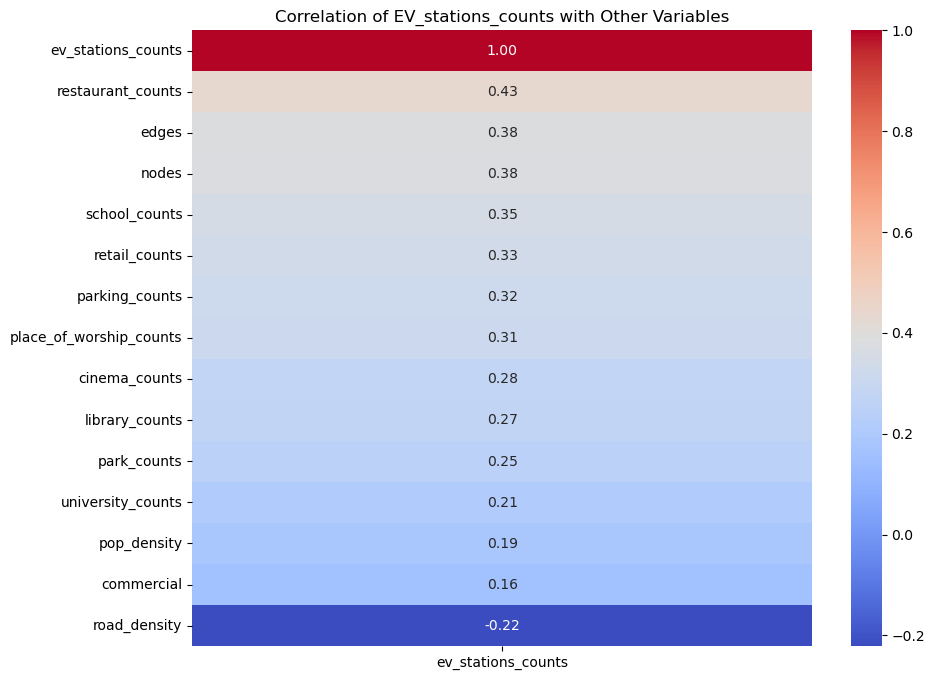

In [8]:
# Calculer la matrice de  correlation matrix avec le nombre de stations par grille
correlation_matrix = df_numeric.corr()['ev_stations_counts'].sort_values(ascending=False)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Correlation of EV_stations_counts with Other Variables')
plt.show()

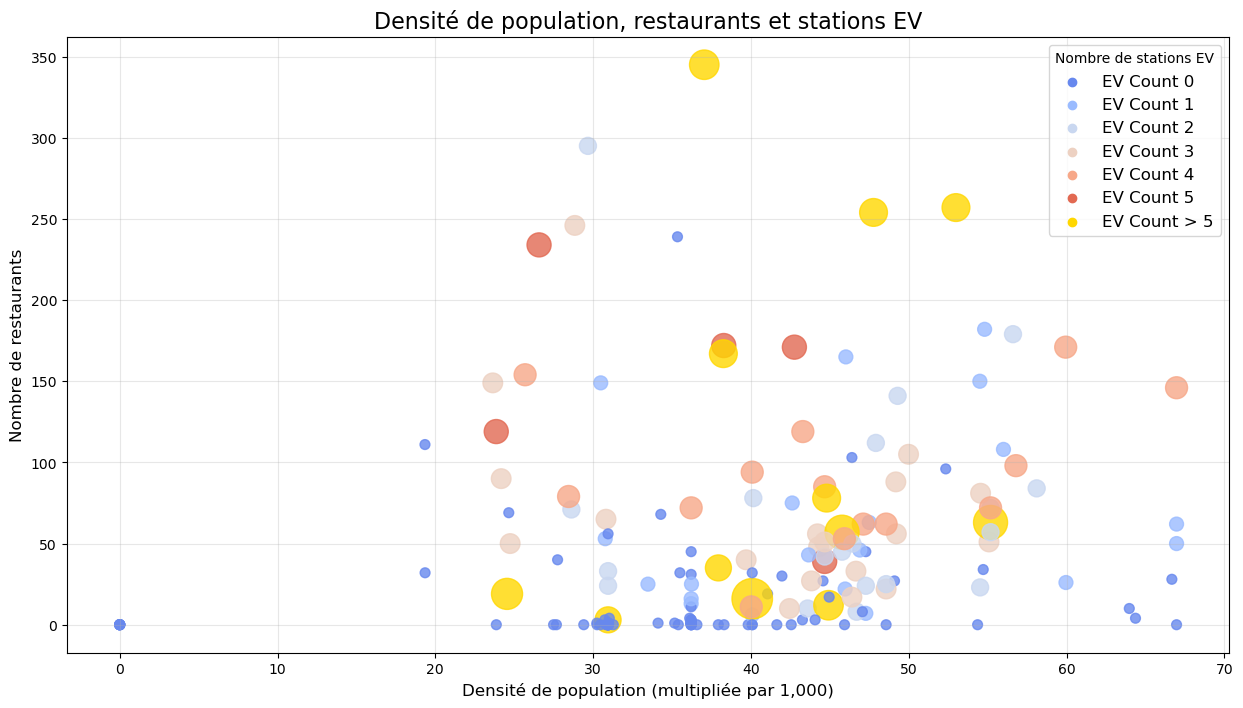

In [9]:
# Définir une palette de couleurs personnalisée et appliquer la correspondance des couleurs
palette_couleurs = sns.color_palette("coolwarm", n_colors=6)
couleurs_ev = df_numeric['ev_stations_counts'].apply(lambda x: palette_couleurs[int(x)] if x <= 5 else 'gold')

# Graphique à bulles
plt.figure(figsize=(15, 8))
plt.scatter(
    df_numeric['pop_density'], 
    df_numeric['restaurant_counts'], 
    s=(df_numeric['ev_stations_counts'] + 1) * 50, 
    alpha=0.8, 
    c=couleurs_ev
)

# Légende et étiquettes
for i in range(6):
    plt.scatter([], [], color=palette_couleurs[i], label=f'EV Count {i}')
plt.scatter([], [], color='gold', label='EV Count > 5')
plt.legend(title='Nombre de stations EV', fontsize=12)

# Titres et étiquettes en français
plt.title('Densité de population, restaurants et stations EV', fontsize=16)
plt.xlabel('Densité de population (multipliée par 1,000)', fontsize=12)
plt.ylabel('Nombre de restaurants', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [10]:
def get_df_from_url(url):
    # Send a GET request to the API URL
    req = requests.get(url)
    
    # Ensure the request was successful (status code 200)
    if req.status_code == 200:
        wb = req.json()  # Parse the JSON response
        
        # Check if the response is directly a list of records
        if isinstance(wb, list):
            # Directly normalize the list of records into a DataFrame
            df = pd.json_normalize(wb)
        else:
            # If the response contains a 'results' key, normalize that
            df = pd.json_normalize(wb.get("results", []))
        
        return df
    else:
        # Handle failed request (non-200 status code)
        print(f"Failed to retrieve data: {req.status_code}")
        return None

In [11]:
api_url_statique = 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/belib-points-de-recharge-pour-vehicules-electriques-donnees-statiques/exports/json'
df_static = get_df_from_url(api_url_statique)

In [12]:
# Construction d'un dataset sur l'évolution du nombre de stations Belib dans le temps

df_static['date_mise_en_service'] = pd.to_datetime(df_static['date_mise_en_service'])
creation_date = df_static[['date_mise_en_service', 'id_station_local']]

# Supprimer les doublons basés sur l'identifiant unique des stations
creation_date = creation_date.drop_duplicates(subset=['id_station_local'])

# Exclure les lignes correspondant à l'année 2024
creation_date = creation_date[creation_date['date_mise_en_service'].apply(lambda x: x.year != 2024)]
creation_date = (creation_date.groupby('date_mise_en_service')
                     .agg({'id_station_local': 'count'})
                     .rename(columns={'id_station_local': 'stations_created'})
                     .sort_index())

creation_date['cumulative_stations'] = creation_date['stations_created'].cumsum()

# Réinitialiser l'index pour faciliter les manipulations futures
creation_date.reset_index(inplace=True)

# Renommer les colonnes
creation_date.rename(columns={'date_mise_en_service': 'ds', 'cumulative_stations': 'y'}, inplace=True)

# Supprimer les fuseaux horaires des dates
creation_date['ds'] = creation_date['ds'].dt.tz_localize(None)


In [13]:
creation_date.head()

,ds,stations_created,y
0,2021-03-15 00:00:00,2,2
1,2021-03-15 14:41:48,1,3
2,2021-03-15 14:41:49,1,4
3,2021-03-15 14:41:50,3,7
4,2021-03-15 14:41:51,2,9


10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


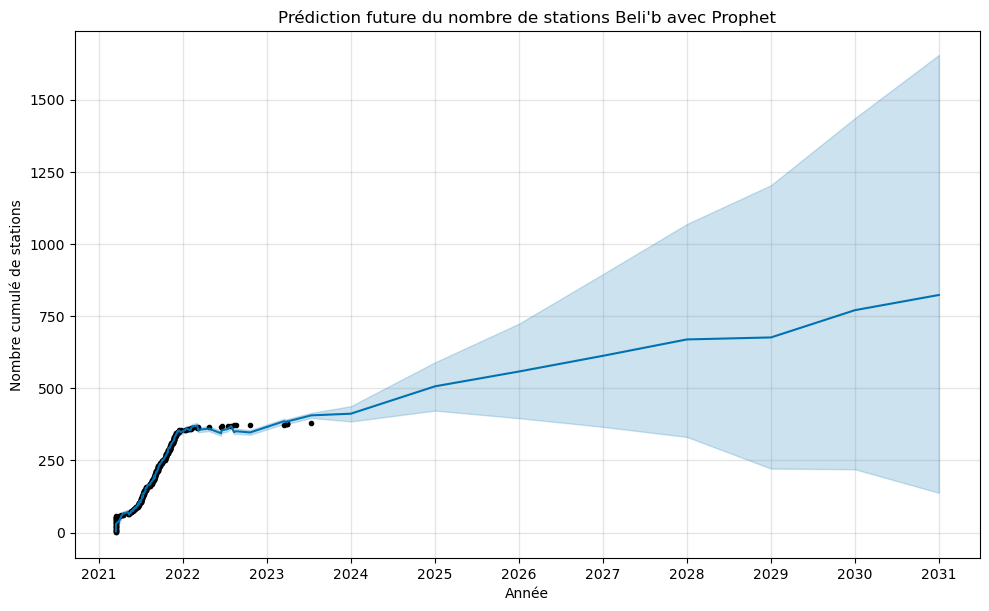

                     ds        yhat  yhat_lower   yhat_upper
347 2023-12-31 13:50:58  411.844498  384.849687   437.857717
348 2024-12-31 13:50:58  506.645979  422.533416   589.804994
349 2025-12-31 13:50:58  557.946161  396.269140   723.666789
350 2026-12-31 13:50:58  612.291041  366.248427   895.229427
351 2027-12-31 13:50:58  669.058738  331.405402  1068.770207
352 2028-12-31 13:50:58  676.022576  221.620562  1203.487124
353 2029-12-31 13:50:58  770.425750  219.298368  1435.648312
354 2030-12-31 13:50:58  823.101869  137.697035  1654.633952


In [14]:
# 2. Création et ajustement du modèle Prophet
# Initialiser le modèle Prophet
model = Prophet()  
# Ajuster (entraîner) le modèle sur les données historiques
model.fit(creation_date)

# 3. Génération des dates futures
# Générer un DataFrame contenant 8 années futures à partir des données historiques
future = model.make_future_dataframe(periods=8, freq='Y')  
# Prédire les valeurs pour les dates futures générées
forecast = model.predict(future)

# 4. Visualisation des prédictions
# Tracer les prédictions générées par le modèle Prophet
model.plot(forecast)
plt.title("Prédiction future du nombre de stations Beli'b avec Prophet")  # Ajouter un titre au graphique
plt.xlabel("Année")  # Étiqueter l'axe des x
plt.ylabel("Nombre cumulé de stations")  # Étiqueter l'axe des y
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8))

In [15]:

# Mélange aléatoirement les lignes du DataFrame pour éviter les biais

df_shuffled = df.sample(frac=1, random_state=42)

# Notre modele sera entrainee sur des donnees numeriques 
df_num = df_shuffled.select_dtypes(include=['float64', 'int64'])

# Notre variables d'etude (station_installed)
df_num['station_installed'] = df_num['ev_stations_counts'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
# Feature selection function
def select_features(X_train, y_train, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)  # Fit and transform training data
    selected_features = X_train.columns[selector.get_support()]  # Get selected feature names
    return pd.DataFrame(X_train_selected, columns=selected_features), selected_features

    
def train_model(X_train, y_train, model):
  """
  Train a machine learning model.
  
  Args:
    X_train (DataFrame): Training feature matrix.
    y_train (Series): Training labels.
    model: Machine learning model instance.
  
  Returns:
    model: Trained model.
  """
  model.fit(X_train, y_train)
  return model

def evaluate_model(model, X_test, y_test, model_name):
  """
  Evaluate a model and print evaluation metrics.
  
  Args:
    model: Trained model.
    X_test (DataFrame): Test feature matrix.
    y_test (Series): Test labels.
    model_name (str): Name of the model.
  """
  predictions = model.predict(X_test)
  print(f"{model_name} Classification Report:")
  print(classification_report(y_test, predictions))
  print(f"Accuracy: {accuracy_score(y_test, predictions)}")
  sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
  plt.title(f'{model_name} Confusion Matrix')
  plt.show()

# Define feature importance extraction
def plot_feature_importance(model, selected_features):
    """
    Plot and print feature importances from a trained model.
    """
    # Extract feature importances
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Print feature importances
    print("\nFeature Importances:")
    print(importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title("Feature Importances (Random Forest)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()



Selected Features: Index(['restaurant_counts', 'library_counts', 'school_counts', 'park_counts',
       'place_of_worship_counts', 'retail_counts', 'nodes', 'edges',
       'road_density', 'pop_density'],
      dtype='object')
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.72      0.88      0.79        26

    accuracy                           0.77        53
   macro avg       0.79      0.78      0.77        53
weighted avg       0.79      0.77      0.77        53

Accuracy: 0.7735849056603774


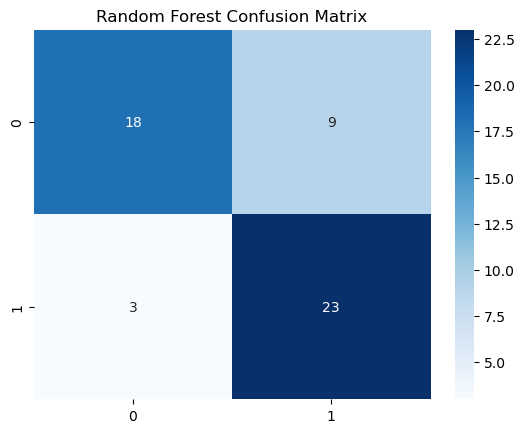

In [17]:
# Assuming df_numeric is your DataFrame
df = df_num

# Define X (features) and y (target)
X = df.drop(columns=['station_installed','ev_stations_counts'])  # Exclude the target column from features
y = df['station_installed']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature selection
X_train_selected, selected_features = select_features(X_train, y_train, k=10)
X_test_selected = X_test[selected_features]
print("Selected Features:", selected_features)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model = train_model(X_train_selected, y_train, rf_model)
evaluate_model(rf_model, X_test_selected, y_test, "Random Forest")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        27
           1       0.66      0.73      0.69        26

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53

Accuracy: 0.6792452830188679


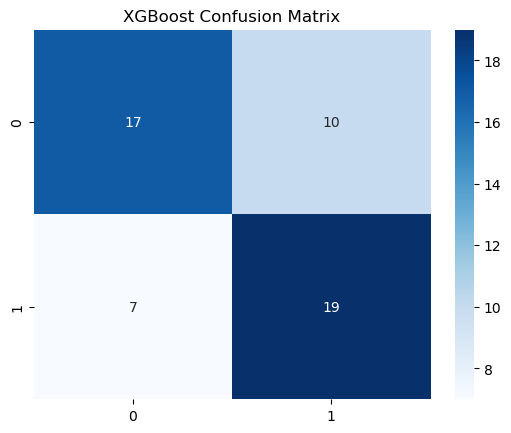

In [18]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model = train_model(X_train_selected, y_train, xgb_model)
evaluate_model(xgb_model, X_test_selected, y_test, "XGBoost")


Feature Importances:
                   Feature  Importance
0        restaurant_counts    0.257535
7                    edges    0.213087
6                    nodes    0.148598
2            school_counts    0.106945
5            retail_counts    0.083069
9              pop_density    0.074124
3              park_counts    0.038716
8             road_density    0.033289
1           library_counts    0.023199
4  place_of_worship_counts    0.021439


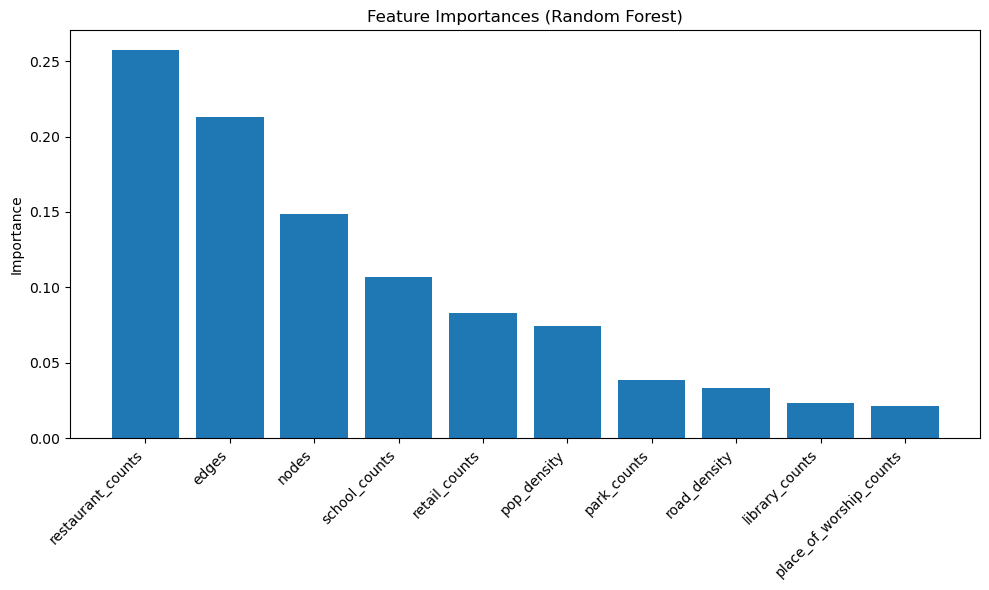

In [19]:

# Plot feature importances
plot_feature_importance(rf_model, selected_features)